# State Vector Machines

## Introduction

## Summary of Results

---

## Setup 

First, we'll need to import the various libraries that we'll need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from svm import SVM

%matplotlib inline

## Load and Clean Data

Before we can build any models, we need to import the data and clean it by converting types as necessary.

In [2]:
df = pd.read_csv("Adult/adult.data", names=[
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "earning_label"
], skipinitialspace=True)

df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,earning_label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
# Explore some attributes of the dataset

# dir(df)
print("Features: ", df.columns)
print("Labels: ", pd.Series.unique(df.earning_label))
print("Shape: ", df.shape)

Features:  Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'earning_label'],
      dtype='object')
Labels:  ['<=50K' '>50K']
Shape:  (32561, 15)


                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours_per_week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


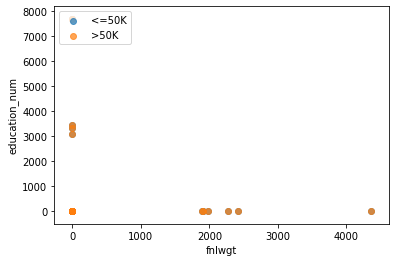

In [4]:
# from itertools import combinations

# labels = combinations(df.columns, 2)
# indices = combinations(range(len(df.columns)), 2)
# for (x_label, y_label), (x1, x2) in zip(labels, indices):
#     for i, target_name in enumerate(pd.Series.unique(df.earning_label)):
#         income = df[ df.earning_label == i ]
#         plt.scatter(income[:,x1], income[:,x2], label=target_name, alpha=0.7)
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.legend(loc='upper left')
#     plt.show()

print(df.describe())

n = 100  # for 2 random indices
index = np.random.choice(df.shape[0], n, replace=False) 
random = df.iloc[index, :]

for i, target_name in enumerate(pd.Series.unique(df.earning_label)):
        income = random[ random.earning_label == i ]
        plt.scatter(random.capital_loss, random.capital_gain, label=target_name, alpha=0.7)
plt.xlabel('fnlwgt')
plt.ylabel("education_num")
plt.legend(loc='upper left')
plt.show()

In [5]:
# Because the native.country variable has too many categories, and most of the data points are from the US (91%), we combine all the categories except for “United-States”into the “Other” category:
df.loc[df['native_country']!='United-States', 'native_country']='Other'

# Save the output label in binary encoding, 0: <=50k, 1: > 50k
Y=pd.Categorical(df['earning_label']).codes
Y = np.where(Y==0, -1, Y) 
print(Y)

# Education is not needed as uducation_num performs its function
# Also drop the label as it is not needed for the model
df=df.drop(['education','earning_label'], axis=1)

# Scale numerical features
col_names = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss','hours_per_week']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df[col_names] = features

df

[-1 -1 -1 ... -1 -1  1]


,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.030671,State-gov,-1.063611,1.134739,Never-married,Adm-clerical,Not-in-family,White,Male,0.148453,-0.21666,-0.035429,United-States
1,0.837109,Self-emp-not-inc,-1.008707,1.134739,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.145920,-0.21666,-2.222153,United-States
2,-0.042642,Private,0.245079,-0.420060,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.145920,-0.21666,-0.035429,United-States
3,1.057047,Private,0.425801,-1.197459,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.145920,-0.21666,-0.035429,United-States
4,-0.775768,Private,1.408176,1.134739,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.145920,-0.21666,-0.035429,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,Private,0.639741,0.746039,Married-civ-spouse,Tech-support,Wife,White,Female,-0.145920,-0.21666,-0.197409,United-States
32557,0.103983,Private,-0.335433,-0.420060,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,-0.145920,-0.21666,-0.035429,United-States
32558,1.423610,Private,-0.358777,-0.420060,Widowed,Adm-clerical,Unmarried,White,Female,-0.145920,-0.21666,-0.035429,United-States
32559,-1.215643,Private,0.110960,-0.420060,Never-married,Adm-clerical,Own-child,White,Male,-0.145920,-0.21666,-1.655225,United-States


In [6]:
# determine unique values of each categorical feature:
col_names = ['workclass','marital_status','occupation','relationship','race','sex','native_country']
for feature in col_names:
    print(feature, pd.Series.unique(df[feature]))

# impute missing values
features = df[col_names]
imp = SimpleImputer(strategy='most_frequent').fit(features.values)
features = imp.transform(features.values)
df[col_names] = features

# Convert categorical features to one-hot encoding
df=pd.get_dummies(df)
df

workclass ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
marital_status ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex ['Male' 'Female']
native_country ['United-States' 'Other']


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native_country_Other,native_country_United-States
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.639741,0.746039,-0.145920,-0.21666,-0.197409,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
32557,0.103983,-0.335433,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
32558,1.423610,-0.358777,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
32559,-1.215643,0.110960,-0.420060,-0.145920,-0.21666,-1.655225,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


In [7]:
# Finally, split the data into training and testing sets 80\/20
train_X, test_X, train_Y, test_Y = train_test_split(df.values, Y, test_size = 0.2)

## Fitting the Model

With the data now processed, it is ready to have SVM applied

In [8]:
svm = SVM(10, .001)
w = svm.fit(train_X, train_Y)
print(w)

[ 0.2150414  -0.0339087   0.55045409  1.674245    0.20884101  0.14994126
 -0.23802211  0.29560811 -0.09213759 -0.00767813 -0.04222973  0.24570025
 -0.4222973  -0.27257371 -0.12668919 -0.29944717  0.16507985  0.62576781
 -0.24186118 -0.55282555 -0.21498771 -0.14204545 -0.24570025 -0.00767813
 -0.0230344  -0.16507985  0.62192875 -0.60273342 -0.36855037 -0.29944717
 -0.41845823 -0.19195332  0.52979115  0.14204545  0.08445946  0.52979115
 -0.24570025  0.10749386 -0.28409091 -0.3531941  -0.4453317  -0.31864251
  0.63344595 -0.28409091 -0.0345516  -0.08445946 -0.24953931 -0.00767813
 -0.52979115 -0.13052826 -0.37238943 -0.28792998 -0.66031941]


In [9]:
predicted_Y = svm.predict(test_X, w)

from sklearn.metrics import accuracy_score

print("Accuracy:")
print ((predicted_Y - test_Y == 0).sum() / test_Y.shape[0])

Accuracy:
0.7632427452786734


In [10]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)
clf.fit(train_X, train_Y)
SVC()
print(clf.predict(test_X))

print(df.values)

[-1 -1 -1 ... -1 -1  1]
[[ 0.03067056 -1.06361075  1.13473876 ...  1.          0.
   1.        ]
 [ 0.83710898 -1.008707    1.13473876 ...  1.          0.
   1.        ]
 [-0.04264203  0.2450785  -0.42005962 ...  1.          0.
   1.        ]
 ...
 [ 1.42360965 -0.35877741 -0.42005962 ...  0.          0.
   1.        ]
 [-1.21564337  0.11095988 -0.42005962 ...  1.          0.
   1.        ]
 [ 0.98373415  0.92989258 -0.42005962 ...  0.          0.
   1.        ]]


In [11]:
predicted_Y = clf.predict(test_X)
print(predicted_Y)

[-1 -1 -1 ... -1 -1  1]


In [12]:
print("Accuracy:")
print ((predicted_Y - test_Y == 0).sum() / test_Y.shape[0])
cm = confusion_matrix(test_Y, predicted_Y)
print("Confusion Matrix")
print(cm)

Accuracy:
0.8489175495163519
Confusion Matrix
[[4644  327]
 [ 657  885]]


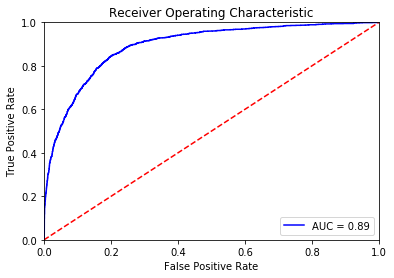

In [13]:
#Plot the ROC curve
probs = clf.predict_proba(test_X)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_Y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Acknowlegements

https://methods.sagepub.com/dataset/howtoguide/support-vector-machine-in-aci-1996-python